## Load and prepare datasets

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_climate_features(df):
    """Extract climate feature columns by dropping metadata columns."""
    return df.drop(columns=['city', 'latitude', 'longitude'])

In [3]:
# Load the datasets from CSV files

period_names = ['1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2020']
datasets = {}

for period_name in period_names:
    datasets[period_name] = pd.read_csv(f"datasets/climate_features_{period_name}.csv")
    print(f"Loaded climate_features_{period_name}.csv with shape {datasets[period_name].shape}")

Loaded climate_features_1970-1979.csv with shape (56, 27)
Loaded climate_features_1980-1989.csv with shape (56, 27)
Loaded climate_features_1990-1999.csv with shape (56, 27)
Loaded climate_features_2000-2009.csv with shape (56, 27)
Loaded climate_features_2010-2020.csv with shape (56, 27)


In [4]:
# Keep only climate features for analysis

climate_ds = {}

for period_name in period_names:
    climate_ds[period_name] = get_climate_features(datasets[period_name])

## Remove highly correlated features

In [5]:
def fuse_datasets(datasets_dict):
    """Fuse multiple datasets into a single dataframe."""
    return pd.concat(datasets_dict.values(), ignore_index=True)

In [6]:
# Fuse all climate datasets into a single dataframe to compute correlations on the whole historcal data

fused_ds = fuse_datasets(climate_ds)

In [7]:
def retrieve_low_correlation_features(df, threshold=0.8):
    """Retrieve features with all pairwise correlations below or equal to the specified threshold.
     Args:
         df (pd.DataFrame): DataFrame containing the features.
         threshold (float): Correlation threshold.
     Returns:
         list: List of feature names with correlations below or equal to the threshold.
    """
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_keep = [column for column in upper_triangle.columns if upper_triangle[column].dropna().le(threshold).all()]

    print(f"Retained {len(to_keep)} features with low correlation (<= {threshold})")
    print("Features retained:", to_keep)

    if len(to_keep) > 0:
        print("Number of features retained:", len(to_keep))
    else:
        print("No features found with all correlations <= threshold.")

    return to_keep

def remove_features_from_df(df, features_to_keep):
    reduced_df = df[features_to_keep]
    print("New shape of the dataset after removing features:", reduced_df.shape)
    return reduced_df  

In [8]:
CORRELATION_THRESHOLD = 0.8

low_correlation_features = retrieve_low_correlation_features(fused_ds, CORRELATION_THRESHOLD)

Retained 7 features with low correlation (<= 0.8)
Features retained: ['sf_winter', 't2m_winter', 't2m_spring', 'tp_winter', 'tp_spring', 'tp_summer', 'si10_winter']
Number of features retained: 7


In [9]:
# Save the column order for future use

joblib.dump(low_correlation_features, 'models/feature_columns.joblib')
print(f"Saved {len(low_correlation_features)} feature column names")

Saved 7 feature column names


In [10]:
fused_ds_reduced = remove_features_from_df(fused_ds, low_correlation_features)

New shape of the dataset after removing features: (280, 7)


## PCA

In [11]:
def compute_pca(df):
    """Compute PCA ans the standard scaler on the given dataframe and return them."""
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    pca = PCA()
    pca.fit(df_scaled)

    return pca, scaler

def display_pca_variance(pca):
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.bar(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
    plt.ylim(0.0, 0.4)
    plt.title('Explained variance')
    plt.xlabel('Index of eigenvector')
    plt.ylabel('Explained variance')
    plt.grid()
    plt.subplot(1,2,2)
    plt.bar(np.arange(len(pca.explained_variance_ratio_)), 100*np.cumsum(pca.explained_variance_ratio_))
    plt.ylim(0.0, 100)
    plt.title('Percent of explained variance')
    plt.xlabel('Index of eigenvector')
    plt.ylabel('Explained variance [%]')
    plt.grid()
    plt.tight_layout()

In [12]:
# Compute PCA on the reduced fused dataset

pca, scaler = compute_pca(fused_ds_reduced)

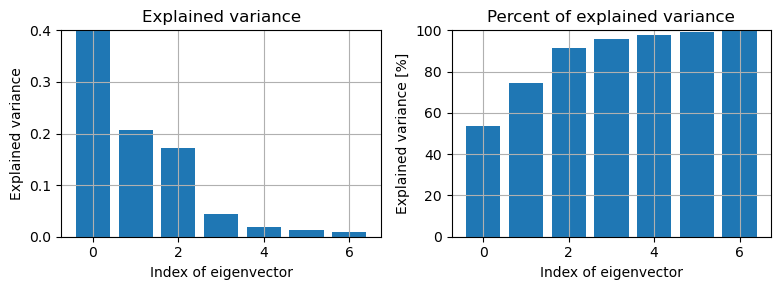

In [13]:
display_pca_variance(pca)

In [14]:
# Save the PCA and scaler models for future use

joblib.dump(pca, 'models/pca_historical.joblib')
joblib.dump(scaler, 'models/scaler_pca_historical.joblib')

['models/scaler_pca_historical.joblib']